# Text Similarity and Clustering
Today we will talk about text similarity and clustering (chapter 6 of the textbook for this class).

## Distance Metric of Similarity
A distance metric of similarity d(x, y), where x and y are entities, needs to satisfy the following four conditions:  
1. The distance between any two entities x and y must always be non-negative: d(x, y) >= 0.  
2. The distance between two entities x and y should always be 0 if and only if they are both identical: d(x, y) = 0, iff x = y.  
3. The distance between two entities x and y should always be symmetric, which means that the distance from x to y is always the same as the distance from y to x: d(x, y) = d(y, x).  
4. The distance  measure should satisfy the triangle inequality: d(x, z) <= d(x, y) + d(y, z).  

## Term Similarity

In [1]:
terms = ['apple', 'pineapple', 'allergy', 'happy', 'apply']

### Character Vectorization
The basic idea is to map each character to a corresponding unique number. In our example, the unique number is equal to the [unicode](https://unicode-table.com/en/) position of that character. 

In [3]:
import numpy as np

def vectorize_terms(terms):
    """Calculates character vector for terms."""
    # Converts terms to lower case.
    terms = [term.lower() for term in terms]
    # Creates array with with every term as a list of its characters.
    terms = [np.array(list(term)) for term in terms]
    # Converts character to number, corresponding to unicode point.
    terms = [np.array([ord(char) for char in term]) for term in terms]
    return terms

In [6]:
vec_terms = vectorize_terms(terms)
vec_terms

[array([ 97, 112, 112, 108, 101]),
 array([112, 105, 110, 101,  97, 112, 112, 108, 101]),
 array([ 97, 108, 108, 101, 114, 103, 121]),
 array([104,  97, 112, 112, 121]),
 array([ 97, 112, 112, 108, 121])]

The advantage is that is it very simple and efficient to implement. The major disadvantage is that there is no relationship between the numbers. To give an example, is 'a' (97) any closer to 'b' (98) than it is to 'z' (122)?

### Bag of Characters Vectorization
This approach is very similar to the bag of words approach that we talked about in week 7 only that this time we use individual characters instead.

In [22]:
from scipy.stats import itemfreq

def create_boc_vectors(terms):
    """Creates bag of character vectors for term list."""
    # Converts terms to lower case.    
    terms = [term.lower() for term in terms]
    # Gets unique characters from terms.
    unique_chars = np.unique(np.hstack([list(term) for term in terms]))
    # Calcualtes character frequency for each term.
    term_counts = [{char: count for char, count in itemfreq(list(term))}
                  for term in terms]
    # Appends vectors.
    boc_vectors = [np.array([int(term_count.get(char, 0)) for char in unique_chars])
                  for term_count in term_counts]
    return list(unique_chars), boc_vectors

Let's apply this function and look at the resulting vector.

In [24]:
unique_chars, boc_vectors = create_boc_vectors(terms)
boc_vectors

[array([1, 1, 0, 0, 0, 1, 0, 2, 0, 0]),
 array([1, 2, 0, 0, 1, 1, 1, 3, 0, 0]),
 array([1, 1, 1, 0, 0, 2, 0, 0, 1, 1]),
 array([1, 0, 0, 1, 0, 0, 0, 2, 0, 1]),
 array([1, 0, 0, 0, 0, 1, 0, 2, 0, 1])]

This is quite difficult to interpret...  
Let's put it in a more eye-friendly format.

In [25]:
import pandas as pd

def display_boc_vectors(terms, unique_chars, boc_vectors):
    """Returns data frame with terms, unique_chars and boc_vectors"""
    return pd.DataFrame(boc_vectors, index=terms, columns=unique_chars)

In [27]:
display_boc_vectors(terms, unique_chars, boc_vectors)

,a,e,g,h,i,l,n,p,r,y
apple,1,1,0,0,0,1,0,2,0,0
pineapple,1,2,0,0,1,1,1,3,0,0
allergy,1,1,1,0,0,2,0,0,1,1
happy,1,0,0,1,0,0,0,2,0,1
apply,1,0,0,0,0,1,0,2,0,1


Much better already, now let's add some colours.  
At this point, you might have to install the 'seaborn' and the 'matplotlib' package.

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_heatmap(df, cmap='Blues', x=10, y=8):
    fig, ax = plt.subplots(figsize=(x, y))   
    return sns.heatmap(df, cmap=cmap, annot=True, mask=df.isnull(), ax=ax)

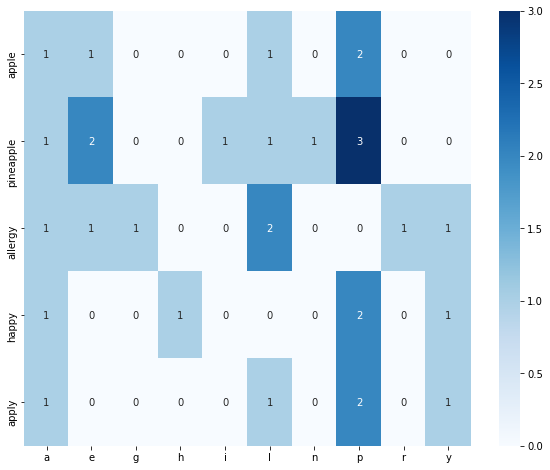

In [29]:
display_heatmap(display_boc_vectors(terms, *create_boc_vectors(terms)))


### Hamming Distance
Hamming distance is a very popular distance metric in information theory and communication systems. It measures the distance between two strings under the assumption that they are of equal length. It is defined as the number of positions that have different characters. You can also normalize it by the total length of the string.

In [31]:
def hamming_distance(vec_a, vec_b, normalize=False):
    if vec_a.shape != vec_b.shape:
        return None
    if not normalize:
        return (vec_a != vec_b).sum()
    else:
        return (vec_a != vec_b).mean()

Let's use it in a simple example: Calculate the distance between 'apple' and 'apply'.

In [37]:
print(hamming_distance(vec_terms[0], vec_terms[4]))
print(hamming_distance(vec_terms[0], vec_terms[4], normalize=True))

1
0.2


It seems useful to have a function that helps us computing similarities between every combination in a list of terms. Let's implement it right away.

In [38]:
def calculate_similarity_matrix(items, similarity_metric, **kwargs):
    similarity_matrix = np.empty((len(items), len(items)))
    similarity_matrix[:] = np.nan
    
    log = []
    for r_index, r_val in enumerate(items):
        for c_index, c_val in enumerate(items):
            if r_index == c_index:
                similarity_matrix[r_index][c_index] = 0              
            elif (c_index, r_index) not in log:
                similarity_matrix[r_index][c_index] = similarity_metric(r_val, c_val, **kwargs)
                log.append((r_index, c_index))
    
    return similarity_matrix

In [40]:
s_matrix = calculate_similarity_matrix(vec_terms, hamming_distance)
s_matrix

array([[ 0., nan, nan,  4.,  1.],
       [nan,  0., nan, nan, nan],
       [nan, nan,  0., nan, nan],
       [nan, nan, nan,  0.,  3.],
       [nan, nan, nan, nan,  0.]])

Now, let's also add a function that returns an eye-friendly version of this table.

In [41]:
def display_similarity_matrix(similarity_matrix, terms):
    df = pd.DataFrame(similarity_matrix, index=terms, columns=terms).T
    df = df[df.columns].astype(float)
    return df

In [42]:
display_similarity_matrix(s_matrix, terms)

,apple,pineapple,allergy,happy,apply
apple,0.0,NaN,NaN,NaN,NaN
pineapple,NaN,0.0,NaN,NaN,NaN
allergy,NaN,NaN,0.0,NaN,NaN
happy,4.0,NaN,NaN,0.0,NaN
apply,1.0,NaN,NaN,3.0,0.0


We can also convert this table into a heatmap.

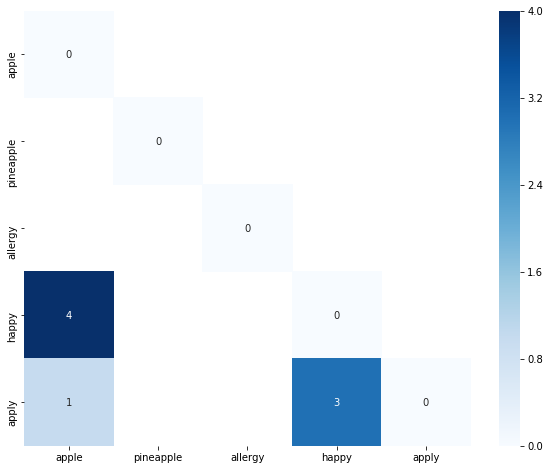

In [43]:
display_heatmap(display_similarity_matrix(s_matrix, terms))

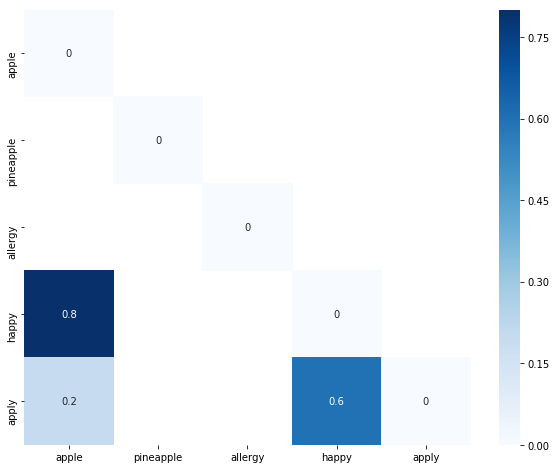

In [44]:
s_matrix = calculate_similarity_matrix(vec_terms, hamming_distance, normalize=True)
display_heatmap(display_similarity_matrix(s_matrix, terms))

### Manhattan Distance

The Mannhattan distance is similar to the Hamming distance, where instead of counting the number of mismatches, we subtract the difference between each pair of characters at each position of two strings. Again, we can normalize this by the length of the string.


In [47]:
def manhattan_distance(vec_a, vec_b, normalize=False):
    if vec_a.shape != vec_b.shape:
        return None
    if not normalize:
        return abs(vec_a - vec_b).sum()
    else:
        return abs(vec_a - vec_b).mean()

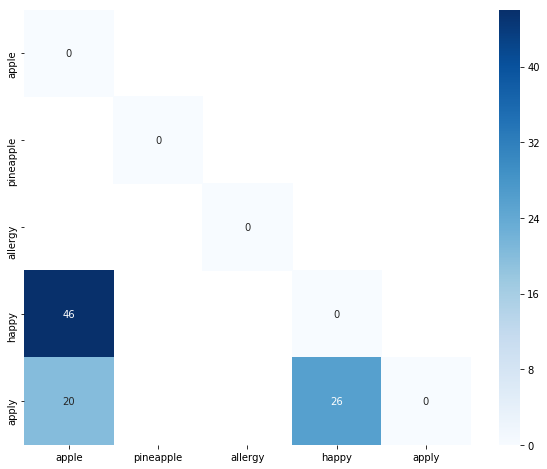

In [48]:
s_matrix = calculate_similarity_matrix(vec_terms, manhattan_distance)
display_heatmap(display_similarity_matrix(s_matrix, terms))

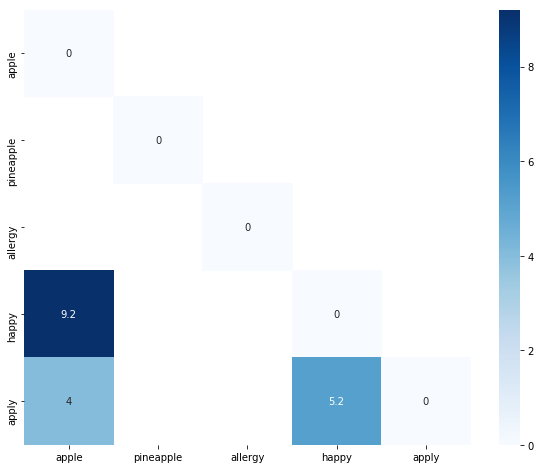

In [50]:
s_matrix = calculate_similarity_matrix(vec_terms, manhattan_distance, normalize=True)
display_heatmap(display_similarity_matrix(s_matrix, terms))

Please be careful when interpreting this plot. Keep in mind that the underlying character conversion is the position in the unicode representation. We can also apply this distance metric to the boc-vectors:

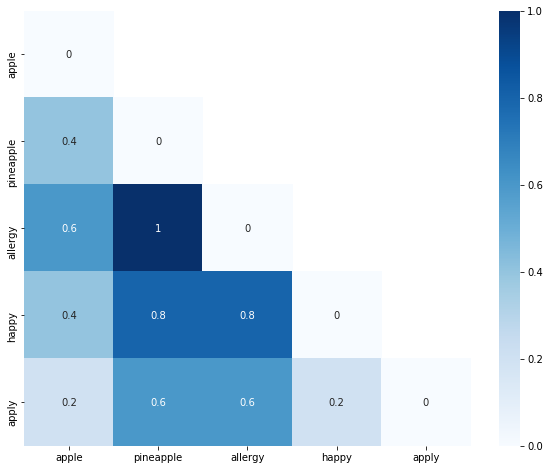

In [52]:
s_matrix = calculate_similarity_matrix(boc_vectors, manhattan_distance, normalize=True)
display_heatmap(display_similarity_matrix(s_matrix, terms))

### Euclidean Distance
The Euclidean distance is very well knows. It is defined as the shortest straingt-line distance between two points.

In [53]:
def euclidean_distance(vec_a, vec_b):
    if vec_a.shape != vec_b.shape:
        return None
    return np.sqrt(np.sum(np.square(vec_a - vec_b)))

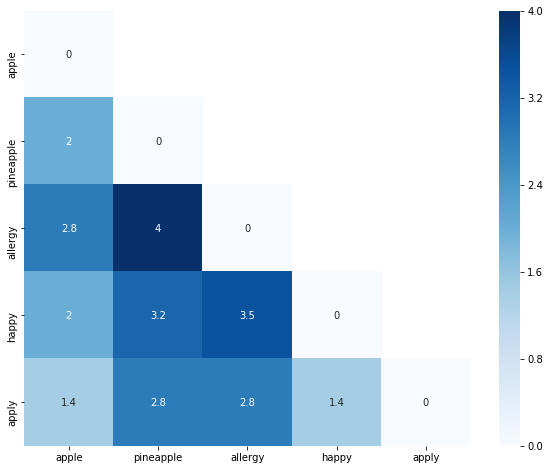

In [55]:
s_matrix = calculate_similarity_matrix(boc_vectors, euclidean_distance)
display_heatmap(display_similarity_matrix(s_matrix, terms))

### Levenshtein Edit Distance
Now that we have the basics sorted out, we can advance to more sophisticated ideas. The edit distance is defined as the number of edits (additions, deletions, substitutions) that are required to convert one term into the other. In standard edit distance, all edits have a cost of 1 associated to them. In Levenshtein edit distance, the substitution operator has a cost of 2. Before we dig into the code, let's start with a pen and paper example: calculate the levenshtein edit distance between 'apple' and 'pineapple'.  

Useful resource: https://www.youtube.com/watch?v=Xxx0b7djCrs&list=LLy-kZFzLfizExUQKV5aPWiQ&index=8&t=0s

In [94]:
def calculate_edit_matrix(vec_a, vec_b, levenshtein=True):
    """Calculates edit matrix for two strings."""

    # Adjust Levenshtein cost factor.
    edit_cost = 2 if levenshtein else 1

    # Create skeleton of edit matrix.
    edit_matrix = np.ndarray(shape=(len(vec_a) + 1, len(vec_b) + 1))
    edit_matrix[:] = np.nan
    # Origin is equal to zero.
    edit_matrix[0, 0] = 0
    # First row values are equal to 1-len(vec_b)
    edit_matrix[0, 1:] = [i for i in range(1, len(vec_b) + 1)]
    # First col values are equal to 1-len(vec_a)
    edit_matrix[1:, 0] = [i for i in range(1, len(vec_a) + 1)]

    def calculate_edit_distance(i, j, vec_a, vec_b, edit_cost):
        """Calculates edit distance at position (i, j) for vec_a and vec_b."""
        # If (i - 1, j) is empty, calculate edit distance for (i- 1, j).
        if np.isnan(edit_matrix[i - 1, j]):
            edit_matrix[i - 1, j] = calculate_edit_distance(i - 1, j, vec_a, vec_b, edit_cost)
        # If (i, j - 1) is empty, calculate edit distance for (i, j - 1).
        if np.isnan(edit_matrix[i, j - 1]):
            edit_matrix[i, j - 1] = calculate_edit_distance(i, j - 1, vec_a, vec_b, edit_cost)
        # If (i - 1, j - 1) is empty, calculate edit distance for (i- 1, j - 1).
        if np.isnan(edit_matrix[i - 1, j - 1]):
            edit_matrix[i - 1, j] = calculate_edit_distance(i - 1, j - 1, vec_a, vec_b, edit_cost)
        # Calculate distances.
        d_1 = edit_matrix[i - 1, j] + 1
        d_2 = edit_matrix[i, j - 1] + 1
        d_3 = edit_matrix[i - 1, j - 1] if vec_a[i - 1] == vec_b[j - 1] else edit_matrix[i - 1, j - 1] + edit_cost
        return (min(d_1, d_2, d_3))

    edit_matrix[len(vec_a), len(vec_b)] = calculate_edit_distance(len(vec_a), len(vec_b), vec_a, vec_b, edit_cost)
    return edit_matrix

In [95]:
e_matrix = calculate_edit_matrix('apple', 'pineapple')
e_matrix

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [1., 2., 3., 4., 5., 4., 5., 6., 7., 8.],
       [2., 1., 2., 3., 4., 5., 4., 5., 6., 7.],
       [3., 2., 3., 4., 5., 6., 5., 4., 5., 6.],
       [4., 3., 4., 5., 6., 7., 6., 5., 4., 5.],
       [5., 4., 5., 6., 5., 6., 7., 6., 5., 4.]])

Some more functions to visualize our results...

In [96]:
def display_edit_matrix(vec_a, vec_b, edit_matrix):
    vec_a = list('#' + vec_a)
    vec_b = list('#' + vec_b)
    return pd.DataFrame(edit_matrix, index=vec_a, columns=vec_b)

This function turns our edit matrix into a distance metric of similarity, by only returning the last cell.

In [63]:
def edit_distance(vec_a, vec_b, levenshtein=True):
    edit_matrix = calculate_edit_matrix(vec_a, vec_b, levenshtein)
    return edit_matrix[-1, -1]

In [64]:
edit_distance('apple', 'pineapple')

4.0

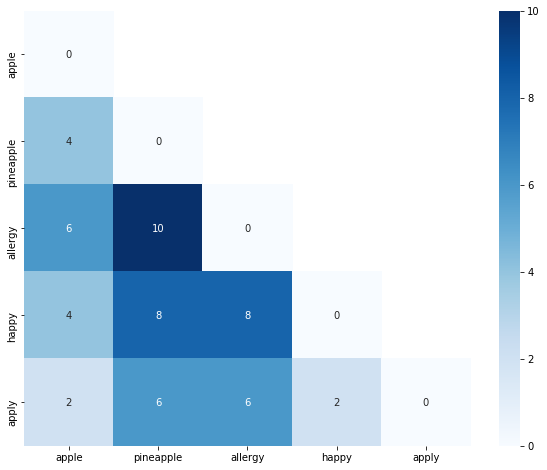

In [65]:
s_matrix = calculate_similarity_matrix(terms, edit_distance)
display_heatmap(display_similarity_matrix(s_matrix, terms))

### Cosine Distance
In order to understand the cosine similarity, we need to go through some very basic trigonometry on the whiteboard...

In [71]:
def cosine_distance(vec_a, vec_b):
    distance = 1 - (
        np.dot(vec_a, vec_b) / 
        (
            np.sqrt(sum(np.square(vec_a))) *
            np.sqrt(sum(np.square(vec_b)))
        )
    )
    return distance

Now, we can apply this metric to our bag of character vectors.

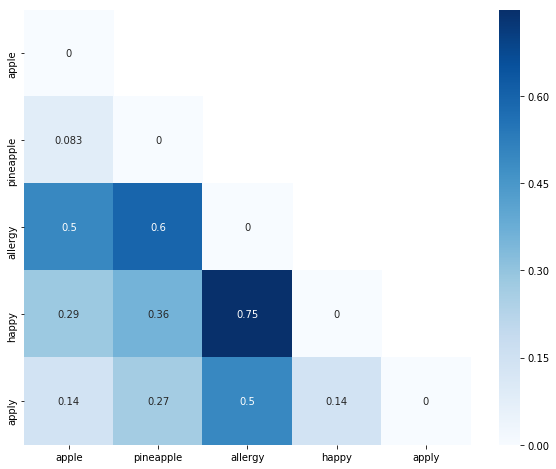

In [72]:
s_matrix = calculate_similarity_matrix(boc_vectors, cosine_distance)
display_heatmap(display_similarity_matrix(s_matrix, terms))

## Document Similarity
Now that we know the basics of how to evaluate similarities between words, we can go one step further and analyze the similarity of documents.

In [93]:
corpus_raw = [
    'the sky is blue',
    'the sky is blue and beautiful',
    'look at the bright blue sky',
    'python is a great programming language',
    'python and java are popular programming languages',
    'among programming languages both python and java are the most used in analytics',
    'the fox is quicker than the lazy dog',
    'the dog is smarter than the fox',
    'the dog the fox and the cat are good friends'
]

### Preprocessing

As always, our first step is to normalize our corpus.

In [74]:
# Normalization #1: Tokenize words.

def tokenize(text):
    return text.split()

In [75]:
# Normalization #2: lemmatization.

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def convert_tags(pos_tag):
    """Converts pos_tag to wordnet."""
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def pos_tag_text(text):
    """Part-of-speach tags text."""
    text = pos_tag(text)
    text = [(term, convert_tags(pos_tag)) for term, pos_tag in text]
    return text

def lemmatize(text):
    """Lemmatizes text."""    
    text = pos_tag_text(text)
    text = [WordNetLemmatizer().lemmatize(term, pos_tag) if pos_tag else term for term, pos_tag in text]
    return text

In [76]:
# Normalization #3: remove stopwords.

from nltk.corpus import stopwords

def remove_stopwords(text):
    # Filter stopwords from text.
    text = [term for term in text if term not in stopwords.words('english')]
    return text

In [78]:
# Normalization #4: re-concatenate words.

def concatenate_text(text):
    return ' '.join(text).strip()

In [79]:
def normalize_text(text):
    text = tokenize(text)
    text = lemmatize(text)
    text = remove_stopwords(text)
    text = concatenate_text(text)
    return text

In [81]:
corpus_normalized = [normalize_text(text) for text in corpus_raw]
corpus_normalized

['sky blue',
 'sky blue beautiful',
 'look bright blue sky',
 'python great programming language',
 'python java popular programming language',
 'among program language python java use analytics',
 'fox quick lazy dog',
 'dog smarter fox',
 'dog fox cat good friend']

Next, we calculate the TF-IDF vectors.

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf_extractor(corpus, ngram_range=(1, 1)):
    vectorizer = TfidfVectorizer(min_df=1,
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [87]:
tfidf_vectorizer, tfidf_features = tfidf_extractor(corpus_normalized)

Let's build a function that represents our TF-IDF matrix in an eye-friendly manner.

In [88]:
def display_tfidf_features(tfidf_features, tfidf_vectorizer, documents):
    df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names(), index=documents)
    df = df.round(2)
    return df

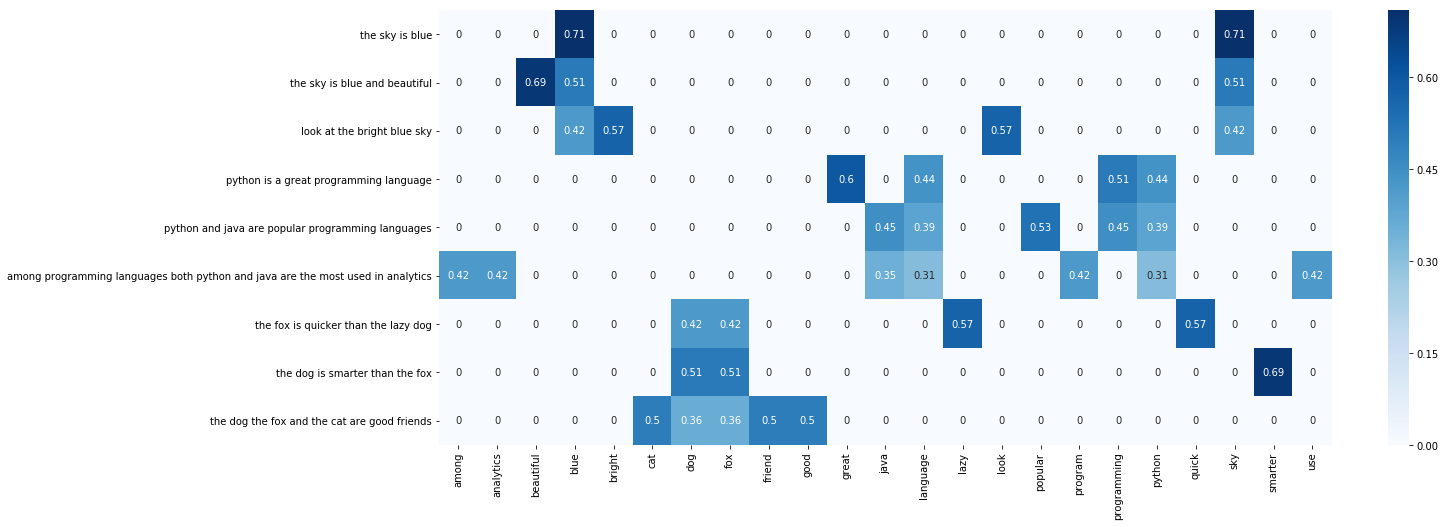

In [91]:
display_heatmap(display_tfidf_features(tfidf_features, tfidf_vectorizer, corpus_raw), x=20, y=8)

### Cosine Distance

We can now use cosine distance on top of our TF-IDF matrix to calculate the similarity between documents.

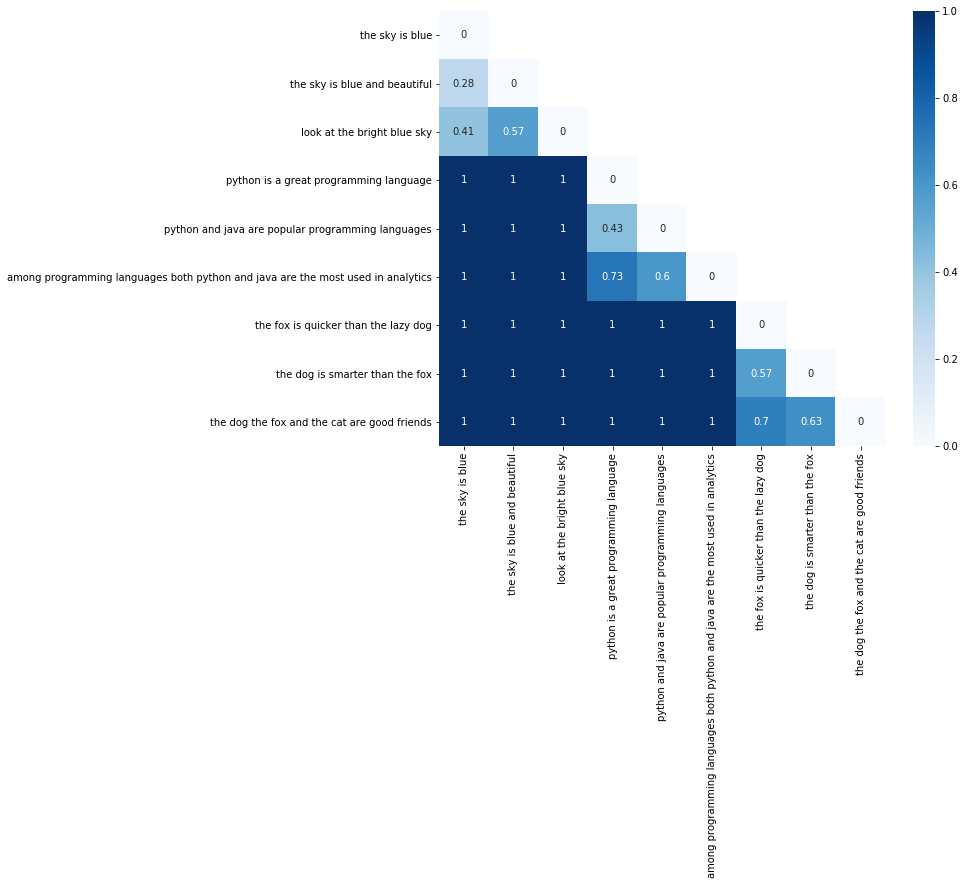

In [92]:
s_matrix = calculate_similarity_matrix(tfidf_features.toarray(), cosine_distance)
display_heatmap(display_similarity_matrix(s_matrix, corpus_raw))

### Jensen Shannon Distance

The Jensen Shannon distance evalautes the similarity between two probability distributions. In order to understand the concept, we will need to clarify some concepts from information theory first, such as entropy and divergence.  

**Useful resources:**  

https://www.youtube.com/watch?v=ErfnhcEV1O8&list=LLy-kZFzLfizExUQKV5aPWiQ&index=3&t=0s  

https://www.youtube.com/watch?v=9r7FIXEAGvs&list=LLy-kZFzLfizExUQKV5aPWiQ&index=1&t=0s

In [100]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

from sklearn.decomposition import LatentDirichletAllocation


lda_model = LatentDirichletAllocation(n_components=3, doc_topic_prior=0.1, topic_word_prior=0.1)
lda_features = lda_model.fit_transform(tfidf_features)

In [101]:
def display_lda_doc_topic(lda_features, index):
    return pd.DataFrame(lda_features, index=index)

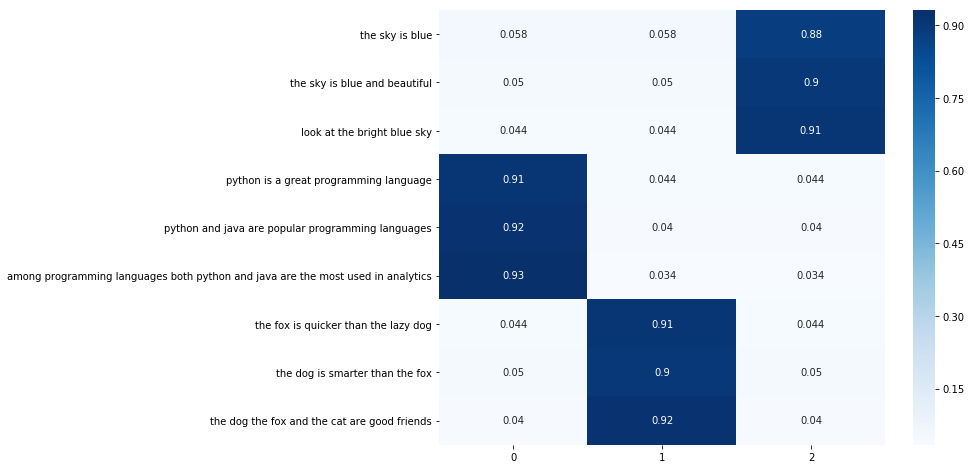

In [102]:
display_heatmap(display_lda_doc_topic(lda_features, corpus_raw))

In [50]:
def display_lda_topic_word(lda_model, words):
    return pd.DataFrame(lda_model.exp_dirichlet_component_, columns=words).T

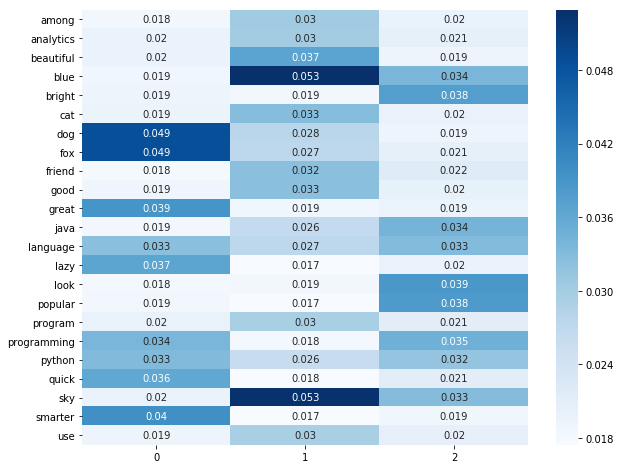

In [51]:
display_heatmap(display_lda_topic_word(lda_model, tfidf_vectorizer.get_feature_names()))

In [104]:
import dit
from dit.divergences import jensen_shannon_divergence

def jensen_shannon_distance(vec_a, vec_b):
    vec_a = dit.ScalarDistribution(vec_a)
    vec_b = dit.ScalarDistribution(vec_b)
    divergence = jensen_shannon_divergence([vec_a, vec_b])
    distance = np.sqrt(divergence)
    return distance

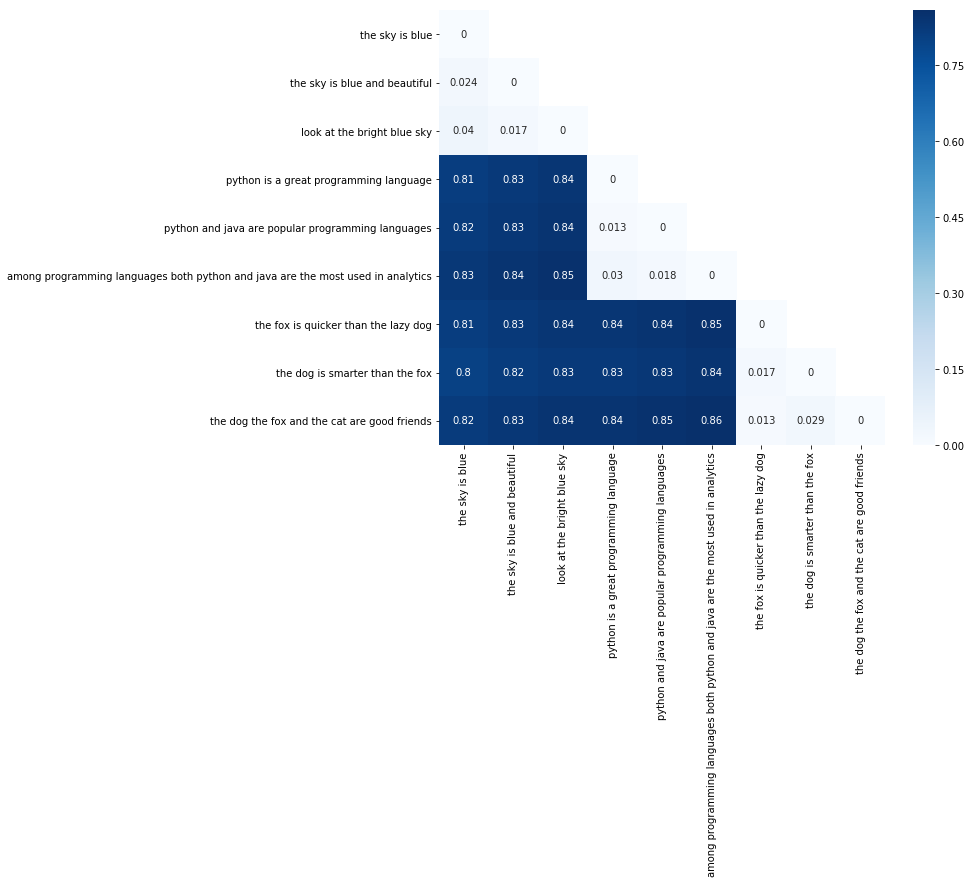

In [105]:
s_matrix = calculate_similarity_matrix(lda_features, jensen_shannon_distance)
display_heatmap(display_similarity_matrix(s_matrix, corpus_raw), y=8)

### Mini Trump Project

In [54]:
# Load data into session.

from pickle import load

with open('country_tweets.pkl', 'rb') as f:
    tweets = list(load(f))

In [55]:
corpus = [t.text_cleaned for t in tweets]
corpus = [' '.join(t) for t in corpus]

In [56]:
tfidf_vectorizer, tfidf_features = tfidf_extractor(corpus)

In [69]:
lda_model = LatentDirichletAllocation(n_components=3, doc_topic_prior=0.5, topic_word_prior=0.5)
lda_features = lda_model.fit_transform(tfidf_features)

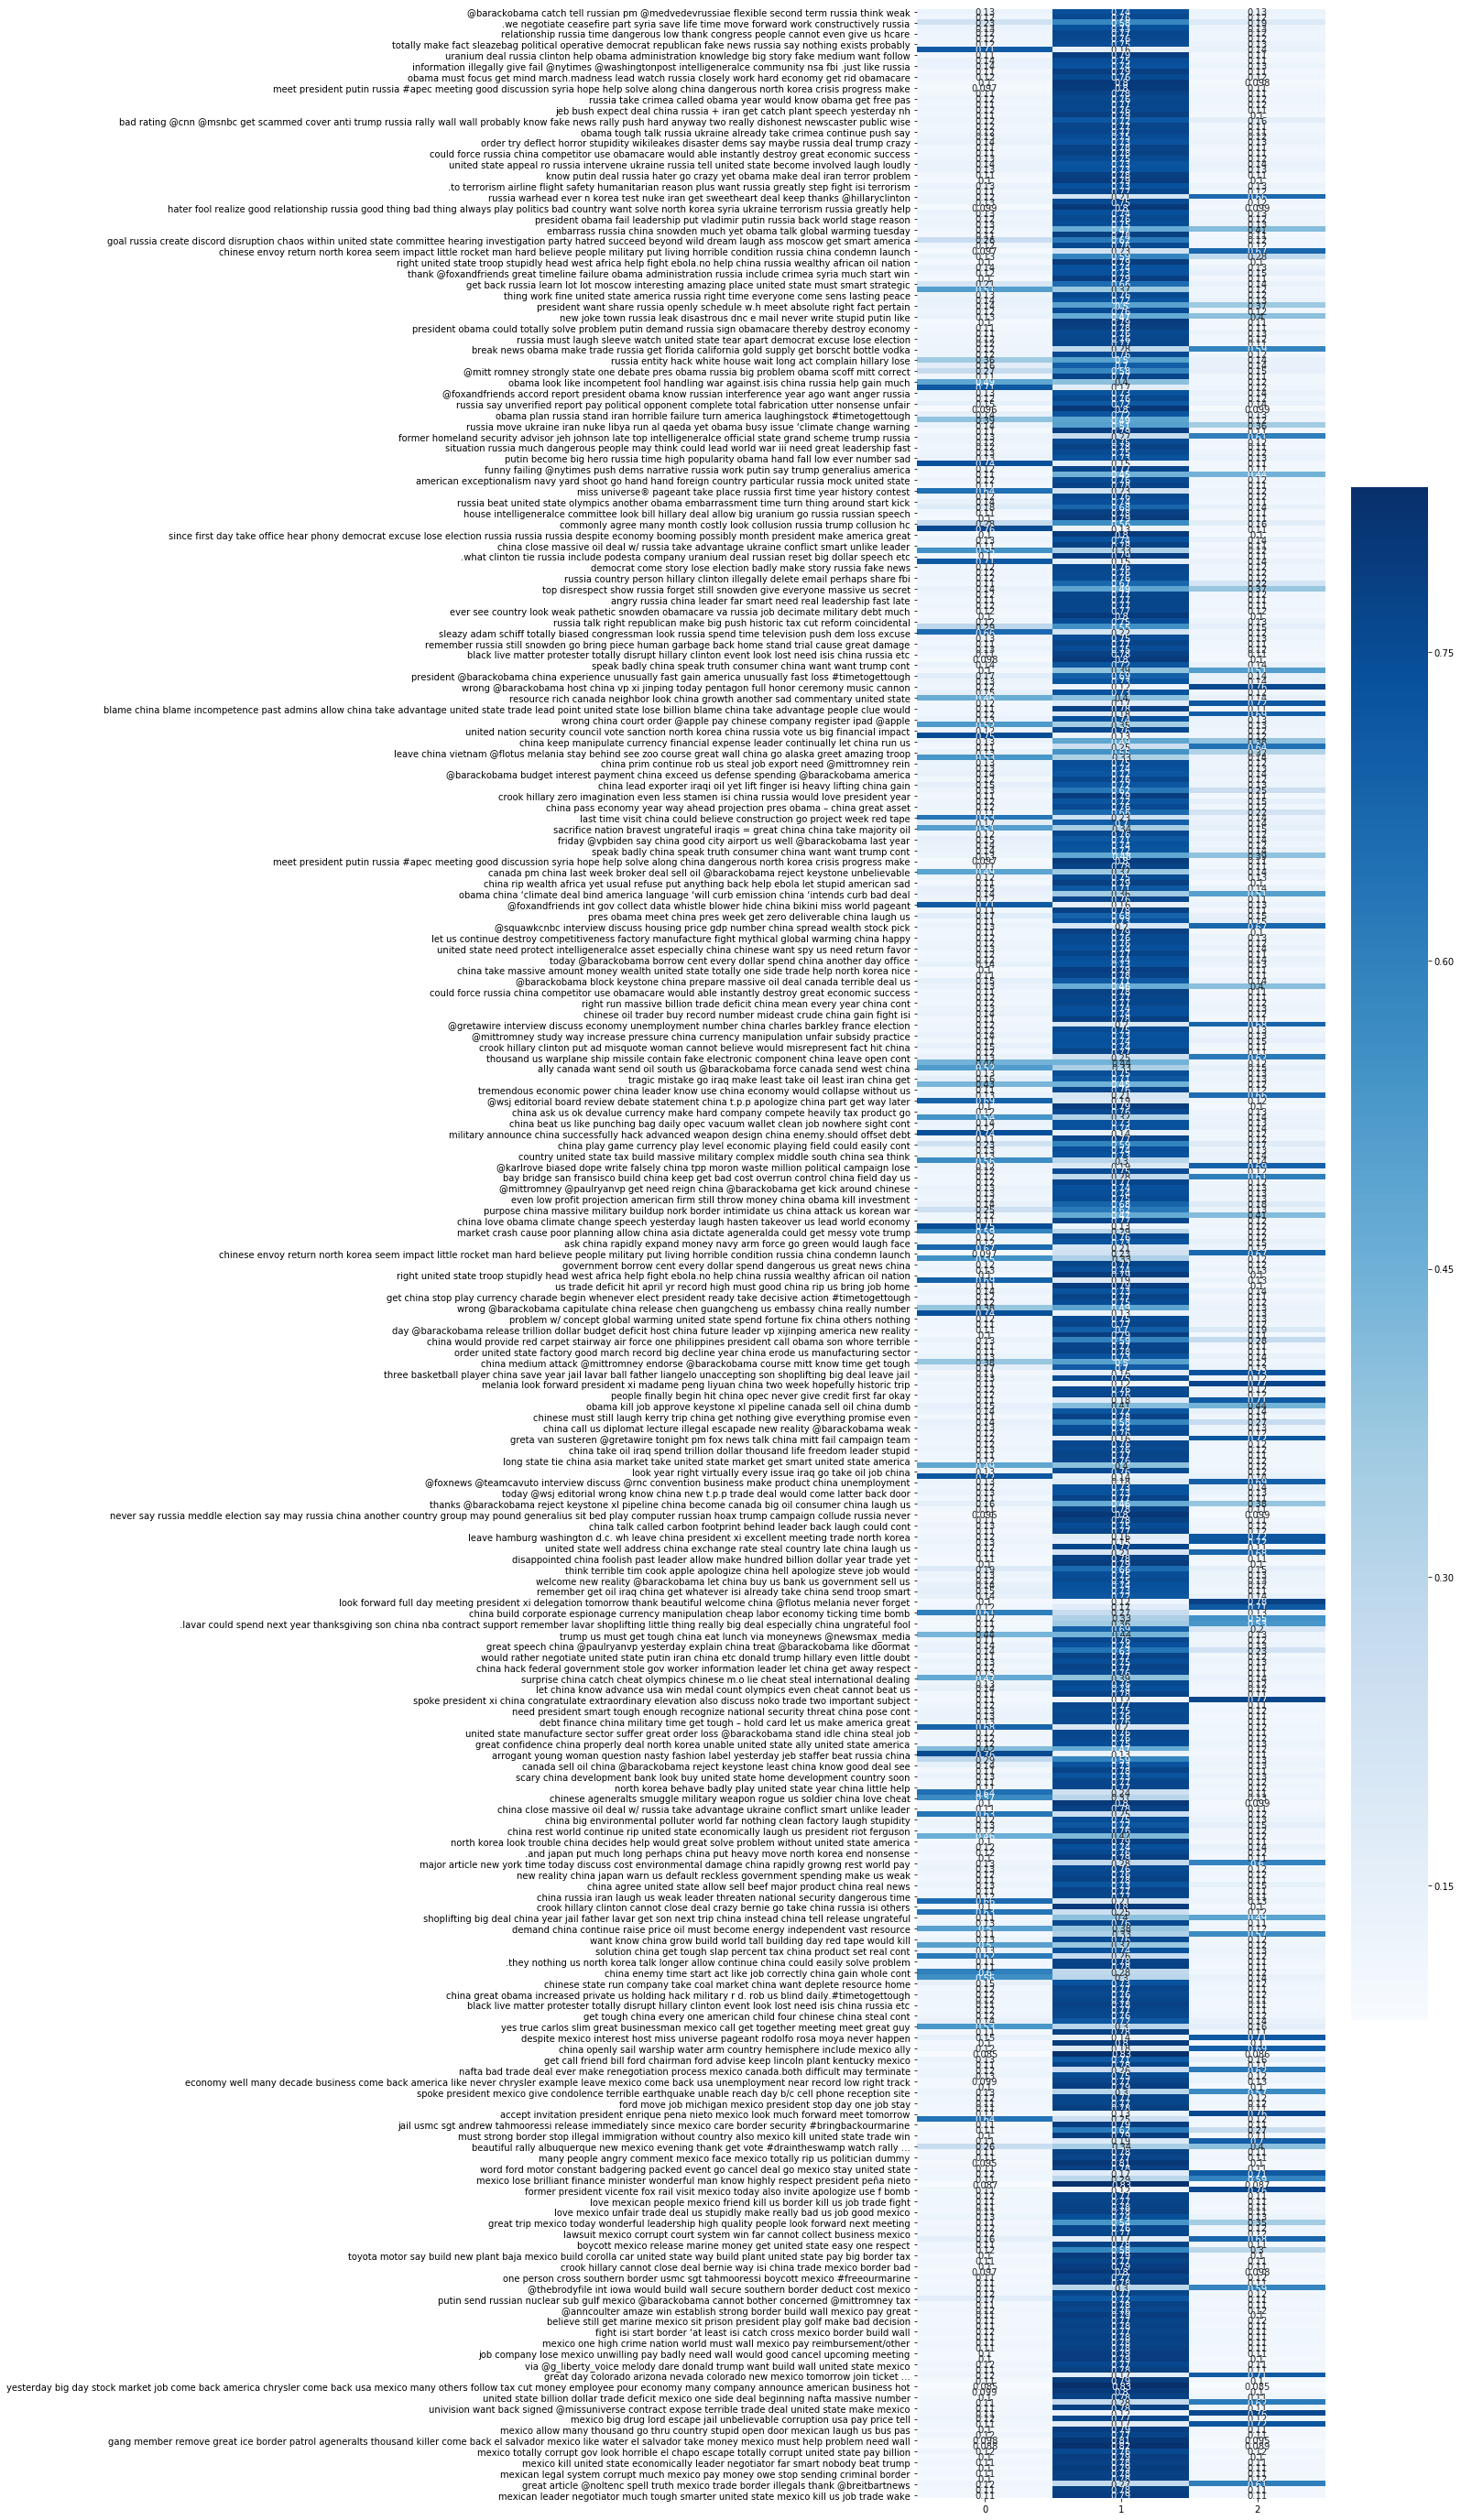

In [70]:
display_heatmap(display_lda_doc_topic(lda_features, corpus), y = 50)